In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
try:
  import lanemod
except (ImportError, KeyError, ModuleNotFoundError):
  !git clone https://github.com/HyungunKim/Software-Fusion-Technology.git ./Project
  !pip install -e ./Project
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()


In [3]:
from google.colab import files

if not 'data' in os.listdir():
  files.upload() #upload kaggle.json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d hyunkunkookminuniv/lanelinedetection
  !unzip -q lanelinedetection.zip -d ./data


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지를 훈련에 활용할수 있는 데이터 포멧으로 변경시키기 0~255의 8비트 정수형 데이터를 0~1의 실수형 데이터로 변환
# batch 사이즈를 8로 불러오고 target_size만큼 만들고 랜덤시드로 전처리하기

SEED = 100

image_data_generator = ImageDataGenerator(
    preprocessing_function=lambda x: x/255
    ).flow_from_directory(f'./data/TrainData', batch_size = 8, target_size = (256, 512), seed = SEED, class_mode=None)

mask_data_generator = ImageDataGenerator(
    preprocessing_function=lambda x: x/255
    ).flow_from_directory(f'./data/TrainLabel', batch_size = 8, target_size = (256, 512), seed = SEED, class_mode=None)

valid_data_generator = ImageDataGenerator(
    preprocessing_function=lambda x: x/255
    ).flow_from_directory(f'./data/ValidData', batch_size = 8, target_size = (256, 512), seed = SEED, class_mode=None)

valid_label_generator = ImageDataGenerator(
    preprocessing_function=lambda x: x/255
    ).flow_from_directory(f'./data/ValidLabel', batch_size = 8, target_size = (256, 512), seed = SEED, class_mode=None)

Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [15]:
from tensorflow import keras
from lanemod.networks import Encoder, Residual, Decoder

# 딥러닝 모델 정의
# 2개의 Pooling 레이어에서 Encoder 작동하고 Residual Block 두번을 거쳐 Upsampling의 Decoder 블록 두개를 거친다.

class LaneNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.e1 = Encoder(3, 32)
    self.e2 = Encoder(32, 64)
    self.r1 = Residual(64, 128)
    self.r2 = Residual(64, 128)
    self.d1 = Decoder(64, 32)
    self.d2 = Decoder(32, 1)

  def call(self, input_tensor, *args, training=True, **kwargs):
    
    e1o = self.e1(input_tensor, training=training)
    e2o = self.e2(e1o, training=training)
    r1o = self.r1(e2o, training=training)
    r2o = self.r2(r1o, training=training)
    d1o = self.d1(r2o, training=training)
    d2o = self.d2(d1o, training=training)

    return tf.math.sigmoid(d2o)


In [16]:
from tensorflow.keras.optimizers import Adam

# 학습할 params는 445,581개 옵티마이저는 아담으로 실행한다.

model = LaneNet()
model.build(input_shape=(None, 256,512,3))
model.compile(optimizer = Adam(lr = 1e4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "lane_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  14976     
                                                                 
 encoder_6 (Encoder)         multiple                  79216     
                                                                 
 residual_5 (Residual)       multiple                  148416    
                                                                 
 residual_6 (Residual)       multiple                  148416    
                                                                 
 decoder_5 (Decoder)         multiple                  51248     
                                                                 
 decoder_6 (Decoder)         multiple                  4851      
                                                                 
Total params: 447,123
Trainable params: 445,581
Non-trai

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# Epoch 5번 만큼 훈련시킨다.

batch_size = 8
steps_per_epoch = 4000//batch_size
validation_batch_size = 5
validation_steps = 1000//validation_batch_size
history = model.fit(zip(image_data_generator, mask_data_generator), validation_data=zip(
    valid_data_generator, valid_label_generator
    ),epochs=5, batch_size=8, steps_per_epoch=steps_per_epoch, validation_batch_size = validation_batch_size, validation_steps = validation_steps)

Epoch 1/5
500/500 [==============================] - 192s 379ms/step - loss: 0.6936 - accuracy: 0.9331 - val_loss: 2940504.0000 - val_accuracy: 0.0219
Epoch 2/5
500/500 [==============================] - 189s 378ms/step - loss: 0.6931 - accuracy: 0.9332 - val_loss: 0.6931 - val_accuracy: 0.9317
Epoch 3/5
500/500 [==============================] - 189s 377ms/step - loss: 0.6931 - accuracy: 0.9346 - val_loss: 0.6931 - val_accuracy: 0.9322
Epoch 4/5
500/500 [==============================] - 189s 378ms/step - loss: 0.6931 - accuracy: 0.9333 - val_loss: 0.6931 - val_accuracy: 0.9332
Epoch 5/5
500/500 [==============================] - 189s 378ms/step - loss: 0.6931 - accuracy: 0.9339 - val_loss: 0.6931 - val_accuracy: 0.9327


In [44]:
X = next(iter(valid_data_generator))
Y = next(iter(valid_label_generator))
Y_pred = model.predict(X)

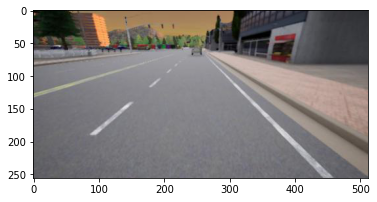

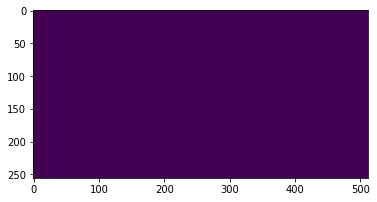

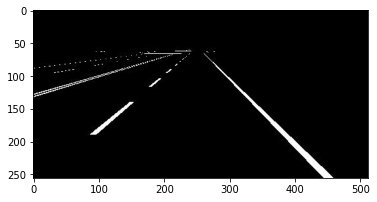

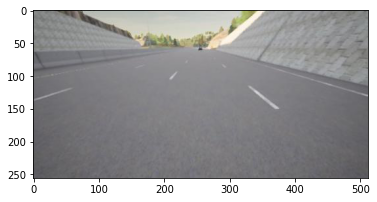

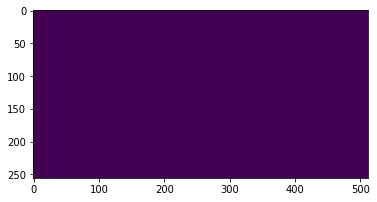

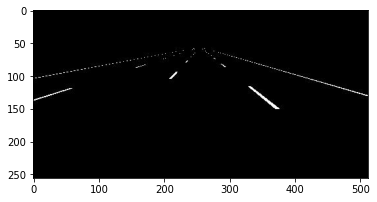

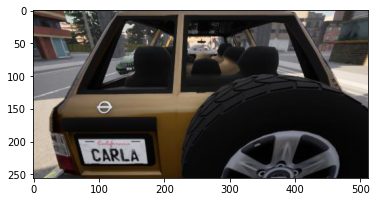

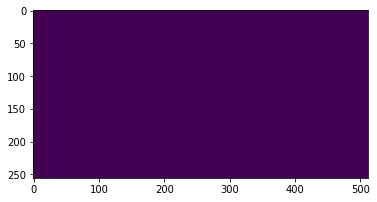

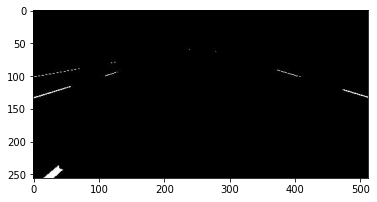

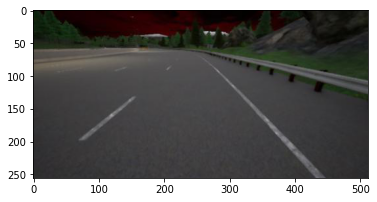

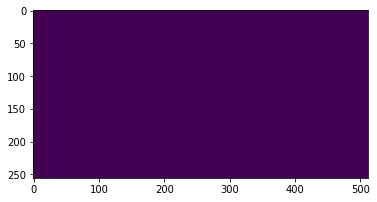

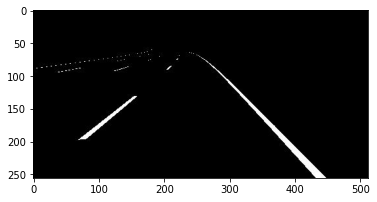

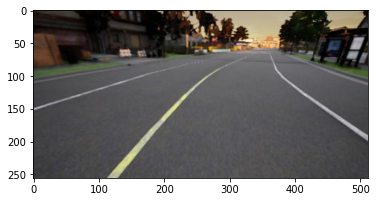

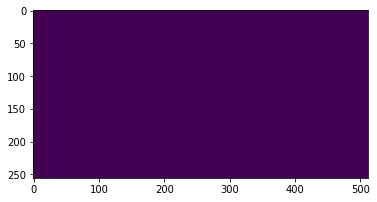

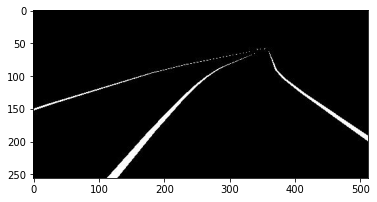

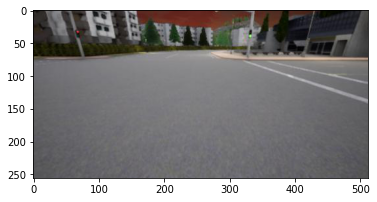

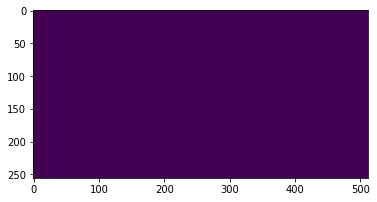

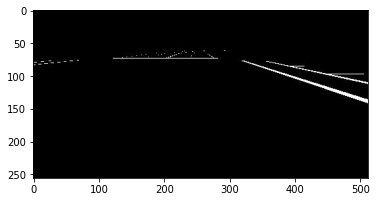

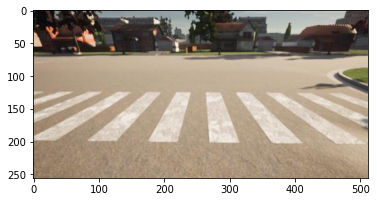

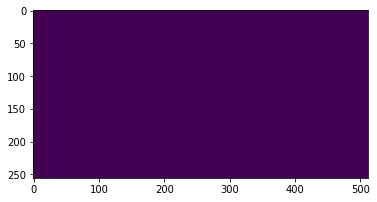

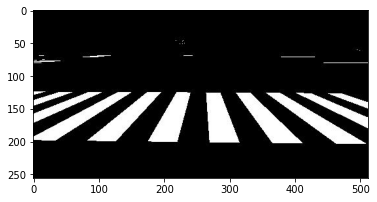

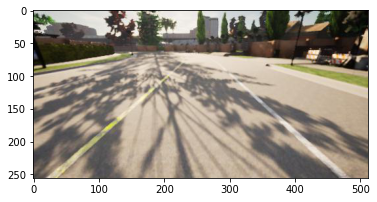

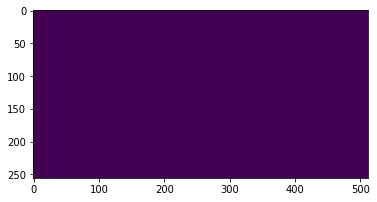

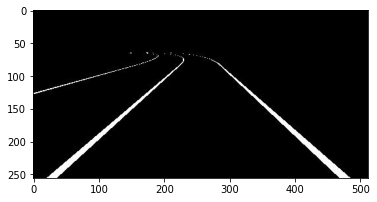

In [45]:
for i in range(8):
  plt.imshow(X[i])
  plt.show()

  plt.imshow(Y_pred[i][:,:,0])
  plt.show()

  plt.imshow(Y[i])
  plt.show()

In [46]:
# 레이어 층을 하나씩 더 추가하여 3개씩 거치도록 변경했다.

class LaneNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.e1 = Encoder(3, 32)
    self.e2 = Encoder(32, 64)
    self.e3 = Encoder(64, 128)

    self.r1 = Residual(128, 256)
    self.r2 = Residual(128, 256)
    self.r3 = Residual(128, 256)

    self.d1 = Decoder(128, 64)
    self.d2 = Decoder(64, 32)
    self.d3 = Decoder(32, 1)

  def call(self, input_tensor, *args, training=True, **kwargs):
    
    e1o = self.e1(input_tensor, training=training)
    e2o = self.e2(e1o, training=training)
    e3o = self.e3(e2o, training=training)
    r1o = self.r1(e3o, training=training)
    r2o = self.r2(r1o, training=training)
    r3o = self.r3(r2o, training=training)
    d1o = self.d1(r3o, training=training)
    d2o = self.d2(d1o, training=training)
    d3o = self.d3(d2o, training=training)

    return tf.math.sigmoid(d3o)

In [47]:
# 훈련할 params 2,440,269개

model = LaneNet()
model.build(input_shape=(None, 256,512,3))
model.compile(optimizer = Adam(lr = 1e4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "lane_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_7 (Encoder)         multiple                  14976     
                                                                 
 encoder_8 (Encoder)         multiple                  79216     
                                                                 
 encoder_9 (Encoder)         multiple                  315104    
                                                                 
 residual_7 (Residual)       multiple                  591744    
                                                                 
 residual_8 (Residual)       multiple                  591744    
                                                                 
 residual_9 (Residual)       multiple                  591744    
                                                                 
 decoder_7 (Decoder)         multiple                  2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
# Epoch 5번 만큼 훈련시킨다.

batch_size = 8
steps_per_epoch = 4000//batch_size
validation_batch_size = 5
validation_steps = 1000//validation_batch_size
history = model.fit(zip(image_data_generator, mask_data_generator), validation_data=zip(
    valid_data_generator, valid_label_generator
    ),epochs=5, batch_size=8, steps_per_epoch=steps_per_epoch, validation_batch_size = validation_batch_size, validation_steps = validation_steps)

Epoch 1/5
500/500 [==============================] - 232s 458ms/step - loss: 0.6935 - accuracy: 0.9325 - val_loss: 0.6931 - val_accuracy: 0.9324
Epoch 2/5
500/500 [==============================] - 228s 455ms/step - loss: 0.6931 - accuracy: 0.9335 - val_loss: 0.6931 - val_accuracy: 0.9324
Epoch 3/5
500/500 [==============================] - 228s 456ms/step - loss: 0.6931 - accuracy: 0.9339 - val_loss: 0.6931 - val_accuracy: 0.9322
Epoch 4/5
500/500 [==============================] - 228s 457ms/step - loss: 0.6931 - accuracy: 0.9333 - val_loss: 0.6931 - val_accuracy: 0.9336
Epoch 5/5
500/500 [==============================] - 228s 457ms/step - loss: 0.6931 - accuracy: 0.9338 - val_loss: 0.6931 - val_accuracy: 0.9314


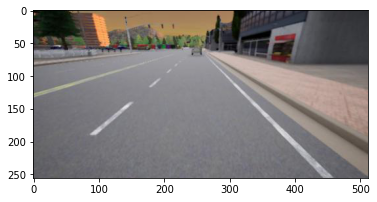

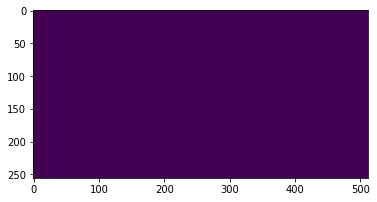

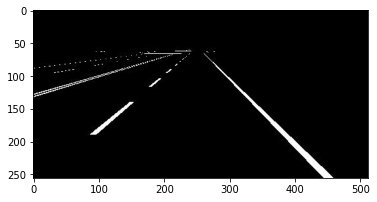

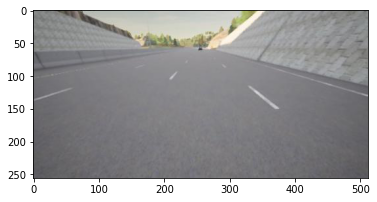

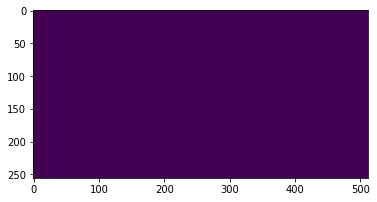

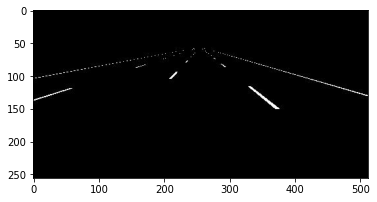

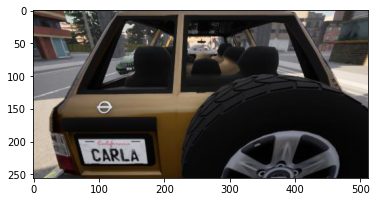

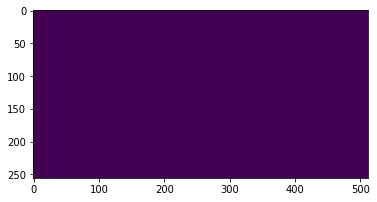

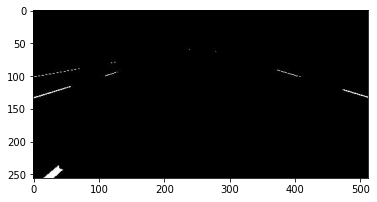

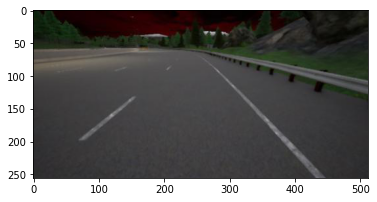

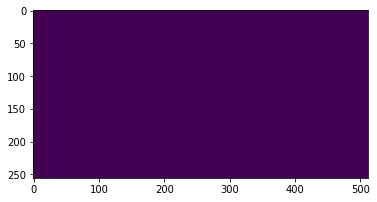

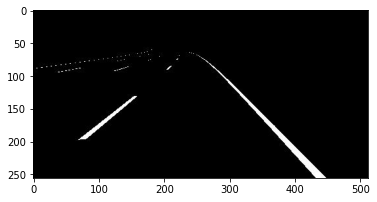

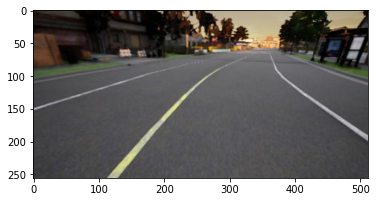

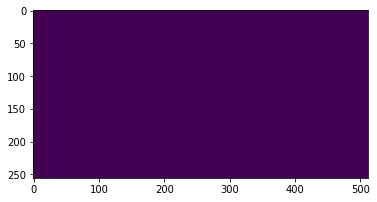

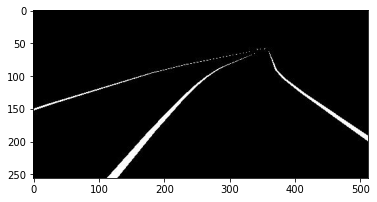

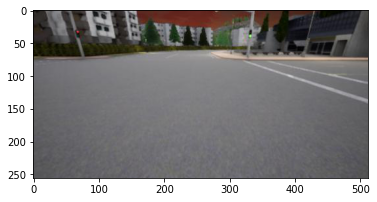

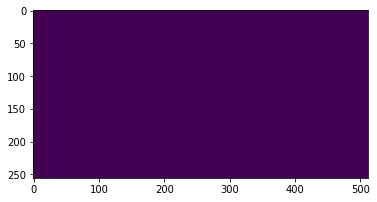

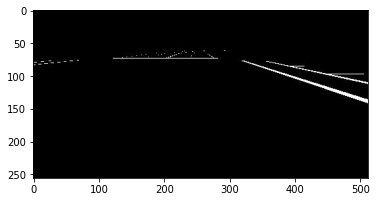

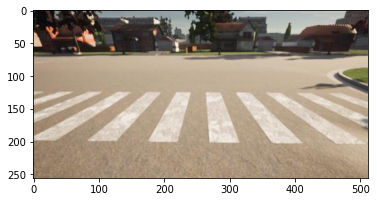

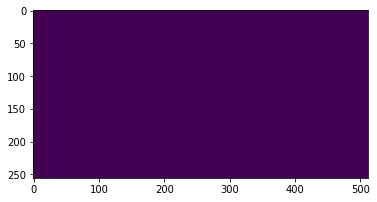

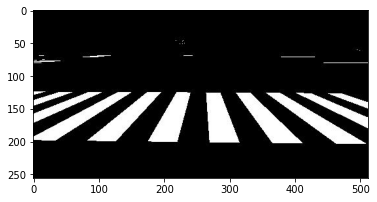

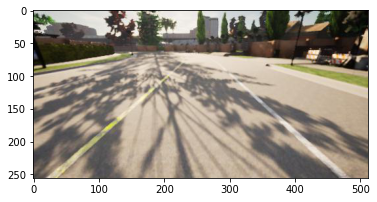

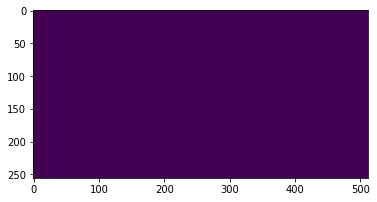

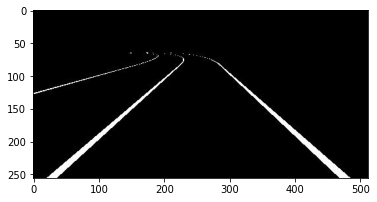

In [50]:
for i in range(8):
  plt.imshow(X[i])
  plt.show()

  plt.imshow(Y_pred[i][:,:,0])
  plt.show()

  plt.imshow(Y[i])
  plt.show()